# Classifying Audio using Spectrograms and CNNs

## Note on Data locations

I recommend putting the audio (WAV) and image (PNG) files in `data\audio` and `data\iamges` directories, respectively.

The `data\` directory is already included in the `.gitignore` file, and so these large binary files won't be included in commits.

### Example:

<img src="data_structure_example.png" style="widht:400px; height:auto;">

## Imports

In [1]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import pickle

In [5]:
class AudioFile:
    """
    A class to handle audio files and provide utilities for analysis and visualization.

    Attributes:
        file_path (str): Path to the audio file.
        file_name (str): Name of the audio file (extracted from the path).
        label (str): Label of the audio file (derived from the parent directory name).
        audio (np.ndarray): Loaded audio data.
        sample_rate (int): Sampling rate of the audio file.
        duration (float): Duration of the audio file in seconds.
    """

    def __init__(self, file_path):
        """
        Initialize the AudioFile instance by loading the audio file and extracting metadata.

        Args:
            file_path (str): Path to the audio file.
        """
        self.file_path = file_path
        self.file_name = os.path.basename(file_path)
        self.label = os.path.basename(os.path.dirname(self.file_path))
        self.audio, self.sample_rate = librosa.load(file_path)
        self.duration = librosa.get_duration(y=self.audio, sr=self.sample_rate)

    def display_waveform(self):
        """
        Display the waveform of the audio file.
        """
        librosa.display.waveshow(self.audio, sr=self.sample_rate)
        plt.show()
        plt.close()

    def play(self):
        """
        Play the audio file.

        Returns:
            IPython.display.Audio: audio player widget.
        """
        return Audio(self.file_path)

    def trim(self, top_db=30):
        """
        Trim silent parts of the audio based on a decibel threshold.

        Args:
            top_db (int, optional): Decibel threshold below which audio is considered silent. Defaults to 30.
        """
        self.audio, _ = librosa.effects.trim(self.audio, top_db=top_db)

    def create_spectrogram(self):
        """
        Create a mel spectrogram of the audio file.

        Returns:
            np.ndarray: The mel spectrogram in decibel units.
        """
        mel_scale_sgram = librosa.feature.melspectrogram(y=self.audio, sr=self.sample_rate, power=1)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        return mel_sgram

    def show_spectrogram(self):
        """
        Display the spectrogram of the audio file.
        """
        _spectrogram = self.create_spectrogram()
        librosa.display.specshow(_spectrogram, sr=self.sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.show()
        plt.close()

    def save_spectrogram(self, output_dir=None, skip_existing=True):
        """
        Save the spectrogram as a PNG file.

        Args:
            output_dir (str, optional): Directory to save the spectrogram. Defaults to the directory of the audio file.
            skip_existing (bool, optional): Whether to skip saving if the file already exists. Defaults to True.
        """
        if not output_dir:
            output_dir = os.path.dirname(self.file_path)
        else:
            output_dir = os.path.join(output_dir, self.label)

        _base, _ = os.path.splitext(self.file_name)
        output_file = os.path.join(output_dir, _base + ".png")

        if skip_existing and os.path.exists(output_file):
            return

        _spectrogram = self.create_spectrogram()
        librosa.display.specshow(_spectrogram, sr=self.sample_rate)

        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(output_file)
        plt.close()


# Data Pipeline

In [2]:
# Define paths
data_folder='data/audio/Speech Commands'
files = [f for f in os.listdir(data_folder) if f != '.DS_Store'] #removes hidden files on Macs
pd.DataFrame(files,columns=['Files']).sort_values(by='Files', ascending=True).reset_index(drop=True)

,Files
0,_background_noise_
1,backward
2,bed
3,bird
4,cat
5,dog
6,down
7,eight
8,five
9,follow


In [3]:
def count(path):
    size = []
    folders = [folder for folder in os.listdir(path) if folder != '.DS_Store']
    for folder in folders:
        folder_path = os.path.join(path, folder)
        files = [file for file in os.listdir(folder_path) if file != '.DS_Store']  # Filter inside subdirectories
        size.append(len(files))
    return pd.DataFrame(size,columns=['Number Of Sample'],index=folders)  
    
file_counts = count(data_folder)
print("File Counts:", f"file_counts")
file_counts.sort_values(by='Number Of Sample', ascending=False)

File Counts: file_counts


,Number Of Sample
five,4052
zero,4052
yes,4044
seven,3998
no,3941
nine,3934
down,3917
one,3890
go,3880
two,3880


## Create time series dataset

In [ ]:
def create_dataset(path):
    file_paths = []
    data = []
    label = []
    sample = []
    durations = []
    folders = [folder for folder in os.listdir(path) if folder != '.DS_Store']
    for folder in folders:
        folder_path = os.path.join(path, folder)
        if os.listdir(folder_path):
            files = [file for file in os.listdir(folder_path) if file != '.DS_Store']
            for fil in files:
                file_path = os.path.join(folder_path,fil)
                audio_file = AudioFile(file_path)
                audio_data = audio_file.audio
                sample_rate = audio_file.sample_rate
                duration = audio_file.duration
                file_paths.append(file_path)
                data.append(audio_data)
                sample.append(sample_rate)
                label.append(folder)
                durations.append(duration)
    return data,file_paths,label,sample,durations

audio_data,file_paths,label,sample,durations = create_dataset(data_folder)
audio_df = pd.DataFrame()
audio_df['file_paths'], audio_df['Label'], audio_df['sample'], audio_df['duration'] = file_paths,label,sample,durations

In [ ]:
# Create a dictionary 
dataset = {
    "audio_data": audio_data,  # List of raw audio arrays
    "file_paths": file_paths,
    "Label": label,
    "sample": sample,
    "duration": durations
}

# Save dictionary to a pickle file
with open("audio_dataset.pkl", "wb") as f:
    pickle.dump(dataset, f)

print("Entire dataset saved to audio_dataset.pkl")

In [2]:
# Open pickle file 
with open("audio_dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

# Extract each component
audio_data = dataset["audio_data"]
file_paths = dataset["file_paths"]
label = dataset["Label"]
sample = dataset["sample"]
durations = dataset["duration"]

audio_df = pd.DataFrame({
    "file_paths": file_paths,
    "Label": label,
    "sample": sample,
    "duration": durations
})

print("Dataset reloaded from pickle.")

Dataset reloaded from pickle.


In [7]:
audio_df

,file_paths,Label,sample,duration,Numbered Label
0,data/audio/Speech Commands\backward\0165e0e8_n...,backward,22050,1.000000,0
1,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.000000,0
2,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.000000,0
3,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.000000,0
4,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.000000,0
...,...,...,...,...,...
105830,data/audio/Speech Commands\_background_noise_\...,_background_noise_,22050,61.805714,35
105831,data/audio/Speech Commands\_background_noise_\...,_background_noise_,22050,61.253878,35
105832,data/audio/Speech Commands\_background_noise_\...,_background_noise_,22050,60.000000,35
105833,data/audio/Speech Commands\_background_noise_\...,_background_noise_,22050,61.155510,35


### Create numbered labels

In [5]:
numbered_labels = {}
start = 0
for i in pd.unique(audio_df.Label):
    numbered_labels[i] = start
    start += 1

pd.DataFrame(numbered_labels.values(),columns=['Value'],index=numbered_labels.keys())

,Value
backward,0
bed,1
bird,2
cat,3
dog,4
down,5
eight,6
five,7
follow,8
forward,9


### Label data with numbered labels

In [6]:
audio_df['Numbered Label'] = audio_df['Label'].apply(lambda x: numbered_labels[x]) 

audio_df

,file_paths,Label,sample,duration,Numbered Label
0,data/audio/Speech Commands\backward\0165e0e8_n...,backward,22050,1.000000,0
1,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.000000,0
2,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.000000,0
3,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.000000,0
4,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.000000,0
...,...,...,...,...,...
105830,data/audio/Speech Commands\_background_noise_\...,_background_noise_,22050,61.805714,35
105831,data/audio/Speech Commands\_background_noise_\...,_background_noise_,22050,61.253878,35
105832,data/audio/Speech Commands\_background_noise_\...,_background_noise_,22050,60.000000,35
105833,data/audio/Speech Commands\_background_noise_\...,_background_noise_,22050,61.155510,35


In [10]:
# Pad the arrays so they are all the same length
audio_data_padded = [
    np.pad(arr, (0, 22050 - len(arr)), mode='constant', constant_values=0)
    for arr in audio_data]

# Create array from list of data arrays
audio_data_arr = np.array(audio_data_padded)

## Exploratory Data Analysis

In [10]:
audio_df.shape

(105835, 5)

In [12]:
def count(path):
    size = []
    folders = [folder for folder in os.listdir(path) if folder != '.DS_Store']
    for folder in folders:
        folder_path = os.path.join(path, folder)
        files = [file for file in os.listdir(folder_path) if file != '.DS_Store']  # Filter inside subdirectories
        size.append(len(files))
    return pd.DataFrame(size,columns=['Number Of Sample'],index=folders)  
    
file_counts = count(data_folder)
file_counts.sort_values(by='Number Of Sample', ascending=False)

,Number Of Sample
backward,1664
bed,2014
bird,2064
cat,2031
dog,2128
down,3917
eight,3787
five,4052
follow,1579
forward,1557


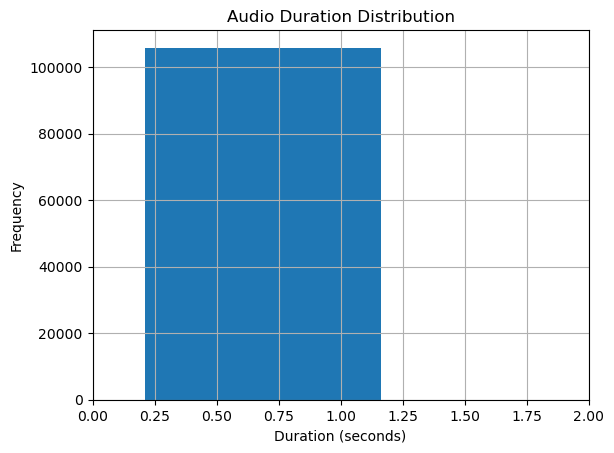

In [9]:
audio_df["duration"].hist(bins=100)
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.xlim(0,2)
plt.show()

In [8]:
# Find how the indeces for files that are less than 1 second
invalid_indices = [i for i, arr in enumerate(audio_data) if len(arr) != 22050]

# Print the # of files less than 1 second
print("# of files less than 1 second:", len(invalid_indices))

# Will put code for padding the data in the data pipeline section

# of files less than 1 second: 10441


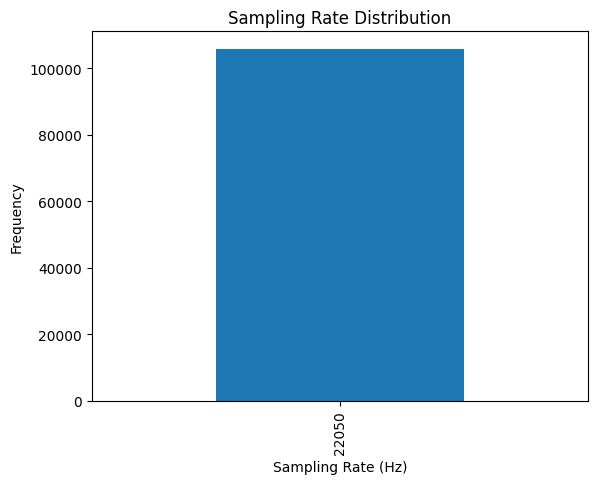

In [17]:
audio_df["sample"].value_counts().plot(kind="bar")
plt.title("Sampling Rate Distribution")
plt.xlabel("Sampling Rate (Hz)")
plt.ylabel("Frequency")
plt.show()

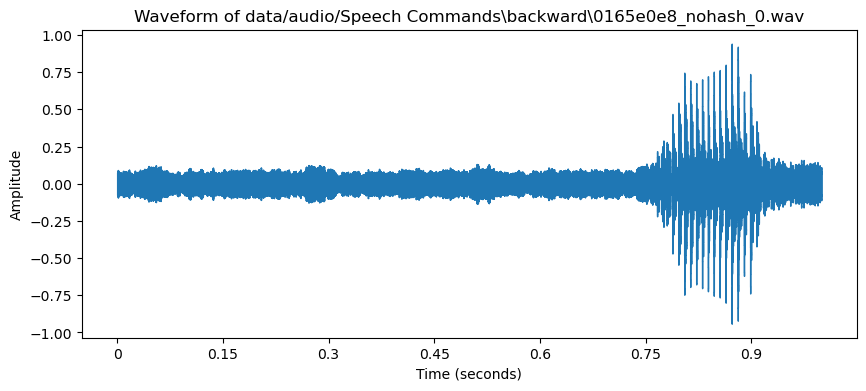

In [11]:
sample_data = audio_data[0]
sr = audio_df['sample'].iloc[0]
plt.figure(figsize=(10, 4))
librosa.display.waveshow(sample_data, sr=sr)
plt.title(f"Waveform of {audio_df['file_paths'].iloc[0]}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

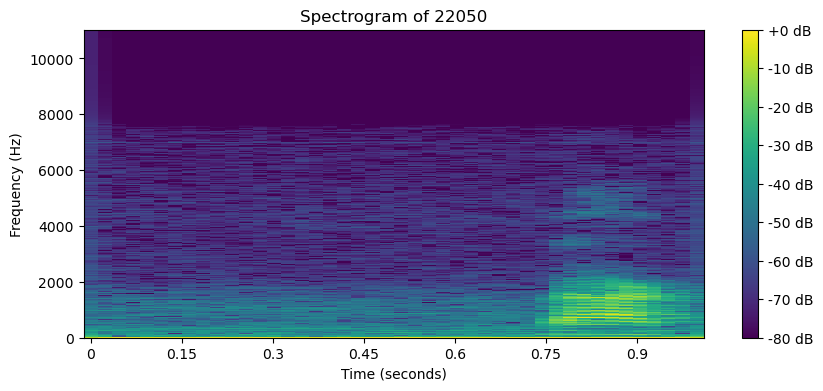

In [12]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="hz", cmap="viridis")
plt.title(f"Spectrogram of {audio_df['sample'].iloc[0]}")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()

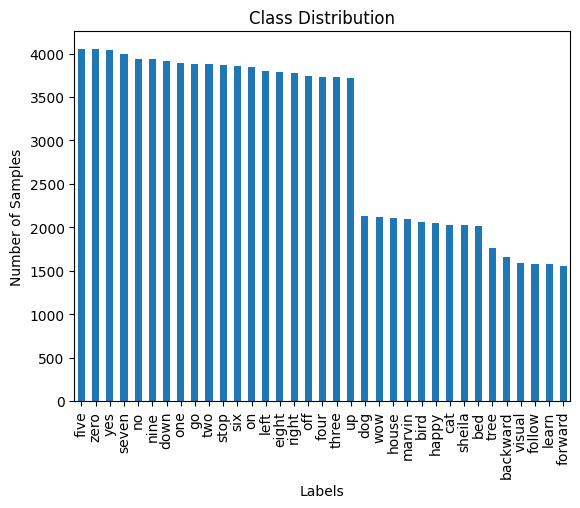

In [20]:
audio_df["Label"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.show()

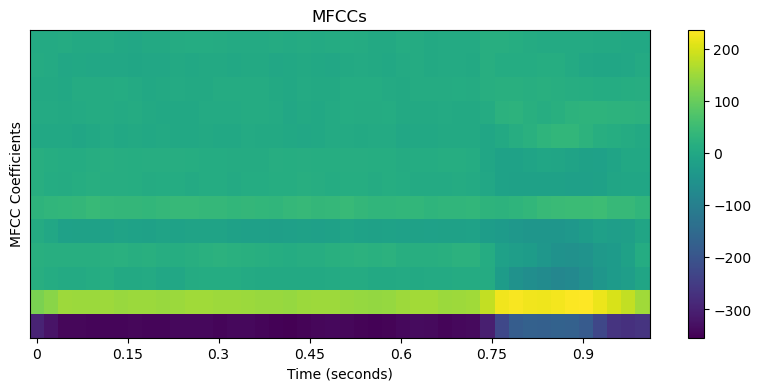

In [13]:
mfccs = librosa.feature.mfcc(y=sample_data, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis="time", cmap="viridis")
plt.title("MFCCs")
plt.colorbar()
plt.xlabel("Time (seconds)")
plt.ylabel("MFCC Coefficients")
plt.show()

## Extracting pitch

In [15]:
# Attempting with librosa normalization
sample_data = audio_data[300]
sr = audio_df['sample'].iloc[0]
f0 = librosa.yin(sample_data, fmin=20, fmax=1000)
print(f0)

[177.39511885 137.49835456 140.09829733 139.01973219 138.43822518
 129.29906985 138.5612119  138.48078253 134.89066247 129.39686242
 132.56654929 130.87755462 130.14674582 130.85361458 134.83766665
 135.54149639 130.99823926 102.59797331  50.67302224 311.30508032
 316.53972039  43.93705334 110.51596409 141.10401641 143.10254659
 146.54632917 198.35466904 564.14667755 577.29081995 583.19267594
  99.85516735 101.06464911 101.36201441 100.78375405 100.80875221
 100.99727326  22.19866086  23.36818147  23.34695718  83.76885915
 329.53954342 335.8411514  347.04835167  44.38453226]


In [23]:
print(np.mean(f0))

168.92215222014883


In [17]:
## Functions to return pitch and average pitch of sample

def return_pitch(sample_num):
    sample_data = audio_data[sample_num]
    f0 = librosa.yin(sample_data, fmin=20, fmax=1000)
    return f0

def average_pitch(sample_num):
    sample_data = audio_data[sample_num]
    f0 = librosa.yin(sample_data, fmin=20, fmax=1000)
    return np.mean(f0)

In [25]:
return_pitch(550)

array([ 70.68767483,  21.5542522 ,  50.79981954,  24.95486899,
        25.0326935 ,  51.01065548,  50.24108197,  50.22145004,
        24.86637158,  24.79756127,  24.7613659 ,  49.17792778,
        49.57774168,  50.05980921,  52.23783638,  48.34091461,
        48.62269542,  49.23782774,  49.6093606 ,  48.859958  ,
        52.67212496, 220.55702361, 202.86583925, 192.26740105,
       185.081117  , 183.28786547, 191.42396584, 214.01867134,
       212.07096207, 209.74221498, 206.75472163, 203.419273  ,
       198.96395319, 183.66986107,  50.02493403,  50.78274063,
       824.91289699,  25.40450473,  53.01161494, 193.85270763,
       168.9341857 , 165.00100855, 164.15119106])

In [18]:
average_pitch(550)

121.33791693189214

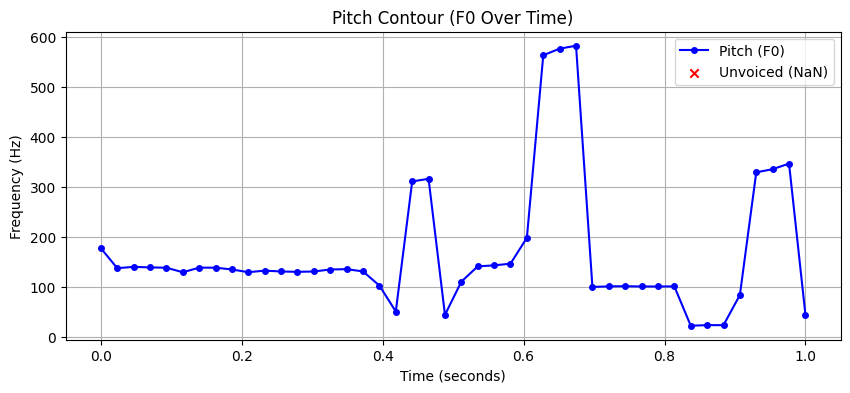

In [27]:
# Compute time axis for f0
times = np.linspace(0, len(sample_data) / sr, num=len(f0))

# Plot the pitch contour
plt.figure(figsize=(10, 4))
plt.plot(times, f0, label="Pitch (F0)", color="blue", marker="o", markersize=4, linestyle="-")

# Mark unvoiced frames (NaN values in f0)
plt.scatter(times[np.isnan(f0)], np.zeros_like(times[np.isnan(f0)]), color='red', label="Unvoiced (NaN)", marker="x")

# Labels
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title("Pitch Contour (F0 Over Time)")
plt.legend()
plt.grid()
plt.show()

In [28]:
# trying different audio sample
sample_data2 = audio_data[60000]
f0 = librosa.yin(sample_data2, fmin=20, fmax=1000)
print(f0)
print(audio_df.iloc[60000])

[632.32426435 782.60298837 115.47280357 101.89753663  64.94259065
  25.91322028 105.61195898 433.09438071 157.279593    61.69782006
 122.25969716 120.13403592 118.60051595 117.91859384 116.19508998
 114.32671194 112.49367688 110.52018743 108.4629966  107.05929796
 106.8393759  107.43598741 112.29251869 123.12863936  32.66466266
 114.88501601  33.9777374   34.45171432 100.65058993  41.71975798
 297.55414361  24.86789683  46.4501533  122.52939285  69.98524968
 165.83737519 164.12862678 277.33325512  78.14151299  47.91151593
 306.41100446 151.93707076  23.68443129  23.7578789 ]
file_paths        data/audio/Speech Commands\one\226537ab_nohash...
Label                                                           one
sample                                                        22050
duration                                                        1.0
Numbered Label                                                   21
Name: 60000, dtype: object


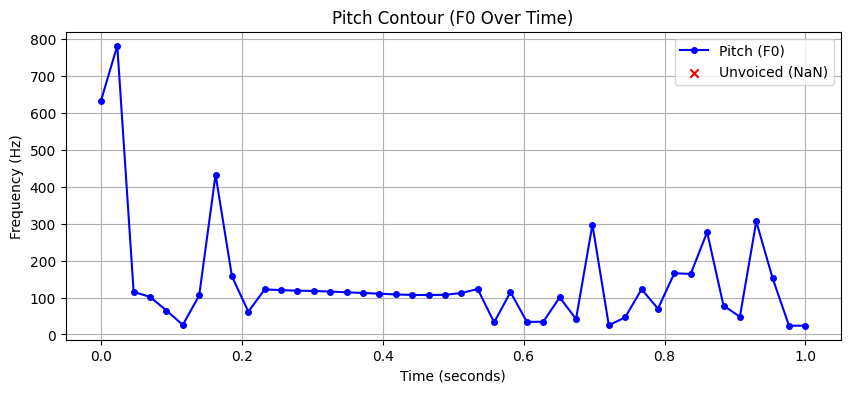

In [29]:
# Compute time axis for f0
times = np.linspace(0, len(sample_data2) / sr, num=len(f0))

# Plot the pitch contour
plt.figure(figsize=(10, 4))
plt.plot(times, f0, label="Pitch (F0)", color="blue", marker="o", markersize=4, linestyle="-")

# Mark unvoiced frames (NaN values in f0)
plt.scatter(times[np.isnan(f0)], np.zeros_like(times[np.isnan(f0)]), color='red', label="Unvoiced (NaN)", marker="x")

# Labels 
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title("Pitch Contour (F0 Over Time)")
plt.legend()
plt.grid()
plt.show()

## Extracting pitch statistics across dataset

In [30]:
dataset_path = r"data\audio\Speech Commands"
# List to store pitch data
pitch_data = []

# Iterate through each word directory
for word in os.listdir(dataset_path):
    word_path = os.path.join(dataset_path, word)
    
    # Check if it's a directory (i.e., a class)
    if os.path.isdir(word_path):
        # Iterate through audio files in the word directory
        for file in os.listdir(word_path):
            if file.endswith(".wav"):
                file_path = os.path.join(word_path, file)
                
                # Load the audio file
                y, sr = librosa.load(file_path, sr=None)
                
                # Compute pitch (F0) using YIN
                # Can change fmin to lower value and fmax to higher value
                f0 = librosa.yin(y, fmin=50, fmax=500)

                # Remove NaNs (unvoiced regions)
                f0 = f0[~np.isnan(f0)]
                
                if len(f0) > 0:  # Only consider files where pitch was detected
                    pitch_data.append({
                        "word": word,
                        "file": file,
                        "mean_f0": np.mean(f0),
                        "median_f0": np.median(f0),
                        "std_f0": np.std(f0),
                        "min_f0": np.min(f0),
                        "max_f0": np.max(f0)
                    })

In [31]:
# Convert to Pandas DataFrame
pitch_df = pd.DataFrame(pitch_data)

# Save to CSV for further analysis
pitch_df.to_csv("pitch_statistics.csv", index=False)

# Display first few rows
print(pitch_df.head())

       word                   file     mean_f0   median_f0      std_f0  \
0  backward  0165e0e8_nohash_0.wav  137.148522   88.974426   81.460232   
1  backward  017c4098_nohash_0.wav  144.911786  119.826446  104.334736   
2  backward  017c4098_nohash_1.wav  141.948204  111.207695  109.615286   
3  backward  017c4098_nohash_2.wav  169.122299  118.557587  118.709701   
4  backward  017c4098_nohash_3.wav  154.573500  146.064696  104.684598   

      min_f0      max_f0  
0  61.079097  409.261369  
1  53.170360  447.479939  
2  50.763738  478.063368  
3  50.990918  501.136364  
4  53.892310  437.991516  


In [32]:
## Visualizing the pitch statistics

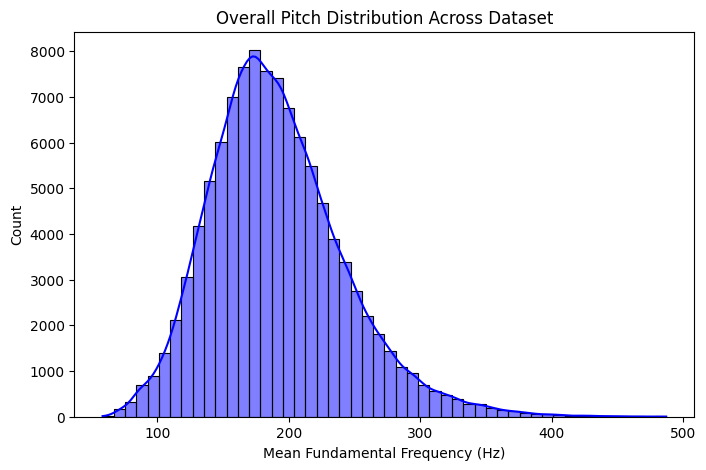

In [33]:
plt.figure(figsize=(8, 5))
sns.histplot(pitch_df["mean_f0"], bins=50, kde=True, color="blue")
plt.xlabel("Mean Fundamental Frequency (Hz)")
plt.ylabel("Count")
plt.title("Overall Pitch Distribution Across Dataset")
plt.show()

In general, the fundamental frequency of the complex speech tone – also known as the pitch or f0 – lies in the range of 100-120 Hz for men, but variations outside this range can occur. The f0 for women is found approximately one octave higher. For children, f0 is around 300 Hz.

https://www.dpamicrophones.com/mic-university/background-knowledge/facts-about-speech-intelligibility/#:~:text=In%20general%2C%20the%20fundamental%20frequency,f0%20is%20around%20300%20Hz.

Our dataset follows this general distrubtion of pitch 

In [34]:
## pitch distribution per word

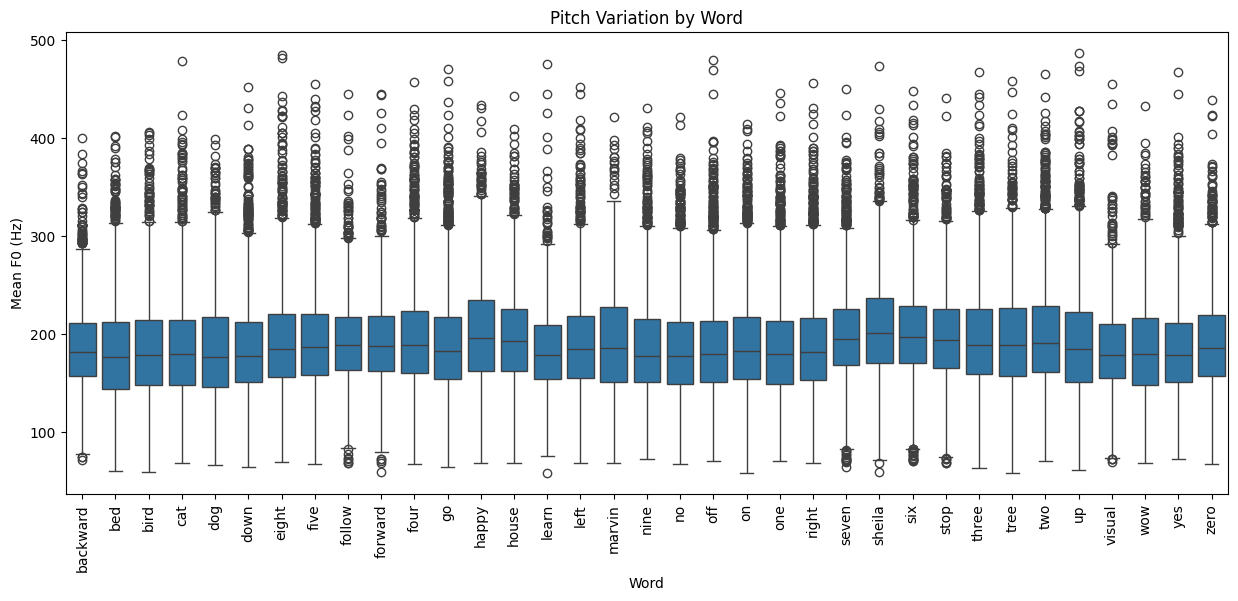

In [35]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=pitch_df, x="word", y="mean_f0")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Mean F0 (Hz)")
plt.title("Pitch Variation by Word")
plt.show()

In [36]:
## Density of Pitch per word

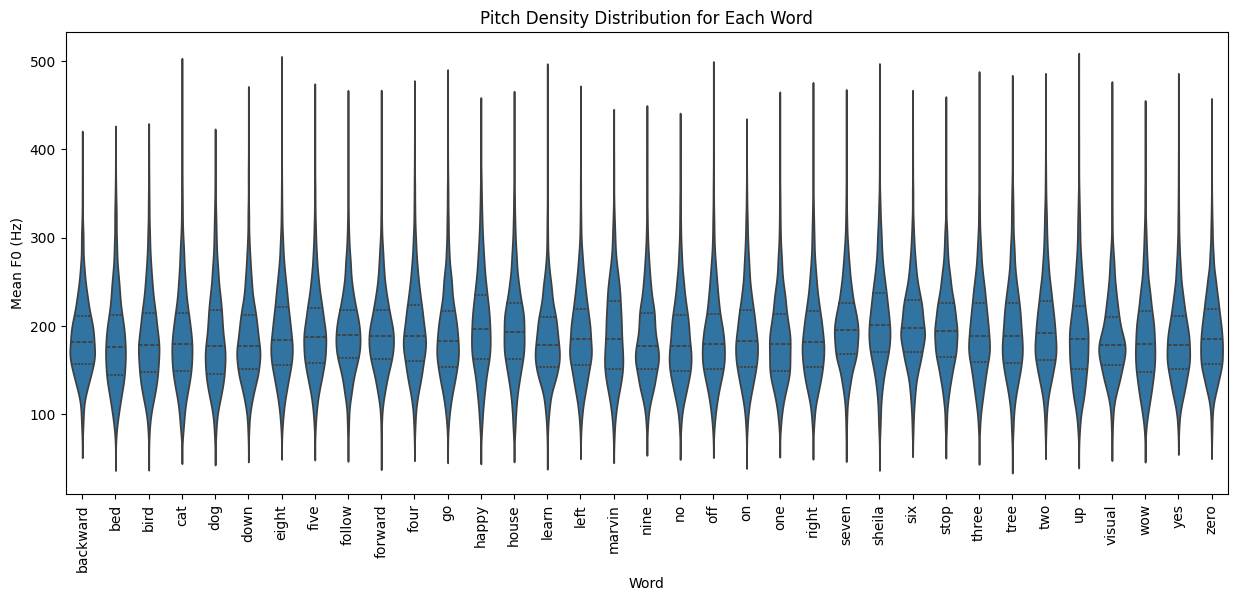

In [37]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=pitch_df, x="word", y="mean_f0", inner="quartile")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Mean F0 (Hz)")
plt.title("Pitch Density Distribution for Each Word")
plt.show()

C:\Users\Parker\AppData\Local\Temp\ipykernel_25428\234779674.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_avg_pitch.index, y=word_avg_pitch.values, palette="coolwarm")


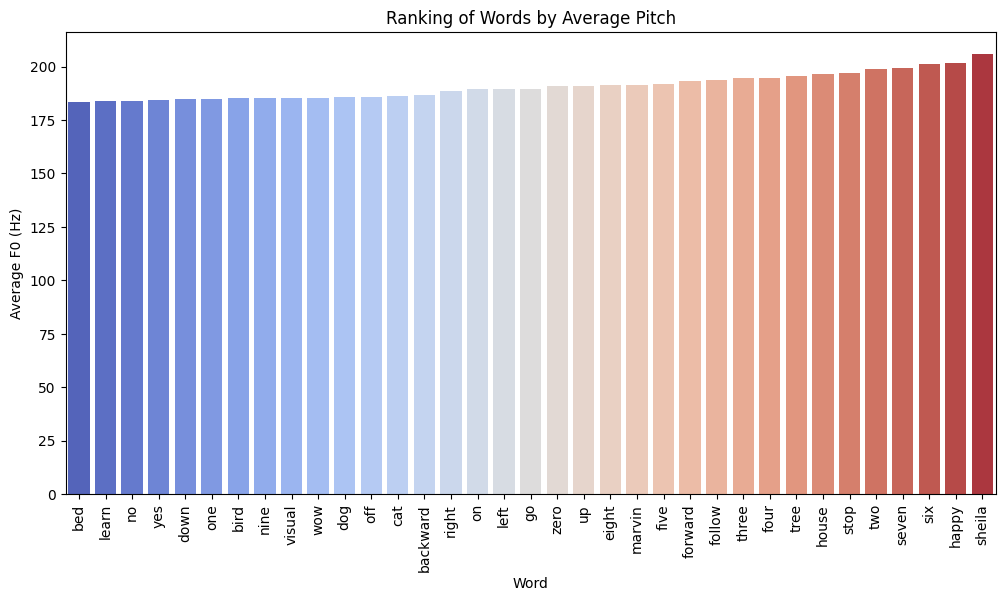

In [38]:
# Sort words by average pitch
word_avg_pitch = pitch_df.groupby("word")["mean_f0"].mean().sort_values()

# Make the plot
plt.figure(figsize=(12, 6))
sns.barplot(x=word_avg_pitch.index, y=word_avg_pitch.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Average F0 (Hz)")
plt.title("Ranking of Words by Average Pitch")
plt.show()

C:\Users\Parker\AppData\Local\Temp\ipykernel_25428\2452879583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_std_pitch.index, y=word_std_pitch.values, palette="viridis")


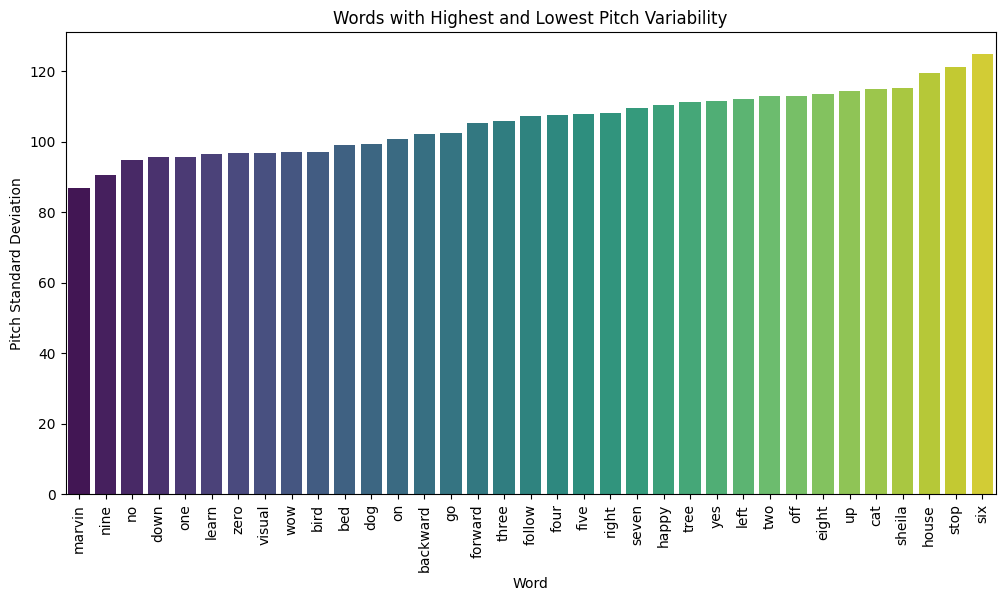

In [39]:
word_std_pitch = pitch_df.groupby("word")["std_f0"].mean().sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x=word_std_pitch.index, y=word_std_pitch.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Pitch Standard Deviation")
plt.title("Words with Highest and Lowest Pitch Variability")
plt.show()

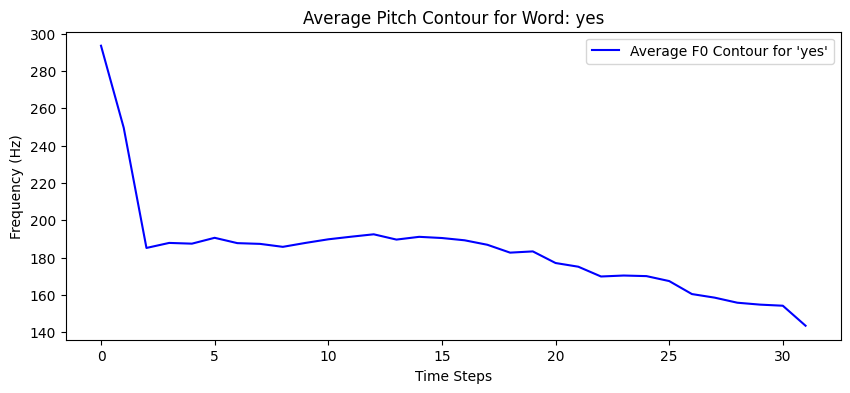

In [40]:
# word to analyze
target_word = "yes"

# Extract pitch sequences 
word_files = pitch_df[pitch_df["word"] == target_word]["file"]

all_f0_curves = []

for file in word_files:
    file_path = os.path.join(dataset_path, target_word, file)
    y, sr = librosa.load(file_path, sr=None)
    f0 = librosa.yin(y, fmin=50, fmax=500)
    f0 = f0[~np.isnan(f0)]  # Remove NaNs
    all_f0_curves.append(f0)

# Compute mean pitch contour
max_len = max(len(f) for f in all_f0_curves)
aligned_f0 = np.array([np.pad(f, (0, max_len - len(f)), mode='constant', constant_values=np.nan) for f in all_f0_curves])
mean_f0_contour = np.nanmean(aligned_f0, axis=0)

# Plot the mean pitch contour
plt.figure(figsize=(10, 4))
plt.plot(mean_f0_contour, label=f"Average F0 Contour for '{target_word}'", color="blue")
plt.xlabel("Time Steps")
plt.ylabel("Frequency (Hz)")
plt.title(f"Average Pitch Contour for Word: {target_word}")
plt.legend()
plt.show()


## Zero crossing rate

In [41]:
sample_data = audio_data[50000]
print(audio_df['file_paths'].iloc[50000])

zcr = librosa.feature.zero_crossing_rate(sample_data)

zcr

data/audio/Speech Commands\no\879a2b38_nohash_2.wav


array([[0.01513672, 0.02636719, 0.07177734, 0.12304688, 0.14599609,
        0.15673828, 0.11669922, 0.07666016, 0.05859375, 0.04931641,
        0.06542969, 0.05761719, 0.04882812, 0.04003906, 0.02246094,
        0.01660156, 0.01611328, 0.01660156, 0.02441406, 0.03808594,
        0.04980469, 0.05908203, 0.06201172, 0.05566406, 0.05078125,
        0.04589844, 0.03857422, 0.03613281, 0.03369141, 0.03173828,
        0.03125   , 0.02978516, 0.03369141, 0.04248047, 0.04296875,
        0.04150391, 0.03320312, 0.02148438, 0.02978516, 0.03173828,
        0.03808594, 0.03857422, 0.02197266, 0.01464844]])

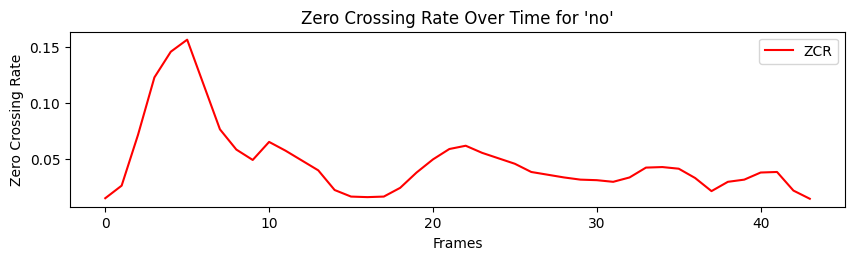

In [42]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 2)
plt.plot(zcr[0], label="ZCR", color="red")
plt.xlabel("Frames")
plt.ylabel("Zero Crossing Rate")
plt.title("Zero Crossing Rate Over Time for 'no'")
plt.legend()
plt.show()

In [43]:
sample_data = audio_data[70000]
print(audio_df['file_paths'].iloc[70000])

zcr = librosa.feature.zero_crossing_rate(sample_data)

zcr

data/audio/Speech Commands\seven\b7e9f841_nohash_0.wav


array([[0.12451172, 0.18212891, 0.25292969, 0.22802734, 0.19628906,
        0.15429688, 0.11181641, 0.08105469, 0.05419922, 0.10205078,
        0.12988281, 0.1796875 , 0.29541016, 0.34130859, 0.40966797,
        0.48535156, 0.49707031, 0.52246094, 0.52929688, 0.5234375 ,
        0.44873047, 0.33740234, 0.25195312, 0.16601562, 0.14794922,
        0.15380859, 0.14355469, 0.13476562, 0.11962891, 0.11962891,
        0.10253906, 0.10693359, 0.10595703, 0.09960938, 0.11669922,
        0.12255859, 0.14257812, 0.16845703, 0.18164062, 0.16503906,
        0.14355469, 0.12451172, 0.07666016, 0.05371094]])

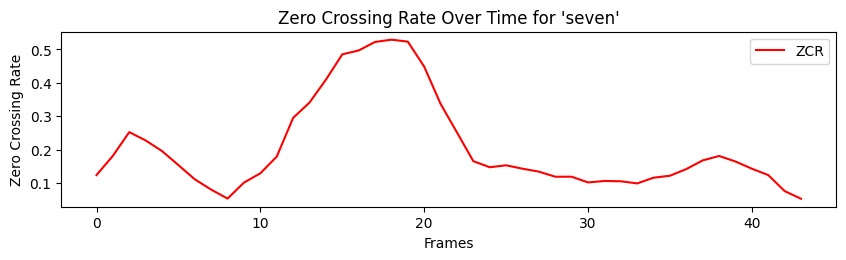

In [44]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 2)
plt.plot(zcr[0], label="ZCR", color="red")
plt.xlabel("Frames")
plt.ylabel("Zero Crossing Rate")
plt.title("Zero Crossing Rate Over Time for 'seven'")
plt.legend()
plt.show()

## Creating Train/Validation/Test sets

In [53]:
import os
from collections import defaultdict

# Define paths
data_dir = "data/images/Speech Commands (trimmed)"  # Root dataset folder
val_list_path = "docs/validation_list.txt"
test_list_path = "docs/testing_list.txt"
train_list_path = "docs/training_list.txt"

In [54]:
# Function to load filenames from validation and test lists
def load_filenames(file_path):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            return set(line.strip().replace(".wav", ".png") for line in f.readlines())
    return set()  # Return empty set if file doesn't exist

In [55]:
# Load validation and test filenames
val_filenames = load_filenames(val_list_path)
test_filenames = load_filenames(test_list_path)

# Combine them to avoid duplicates
excluded_files = val_filenames.union(test_filenames)

# Prepare training list and class distributions
train_filenames = []
class_counts = {
    "train": defaultdict(int),
    "validation": defaultdict(int),
    "test": defaultdict(int)
}

In [56]:
# Iterate through dataset folders (each folder is a word category)
for word_class in sorted(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, word_class)

    # Skip irrelevant folders
    if not os.path.isdir(class_path) or word_class in [".DS_Store", "_background_noise_"]:
        continue

    # Iterate through image files
    for filename in sorted(os.listdir(class_path)):
        if filename.endswith(".png"):  # Ensure it's an image
            file_path = os.path.join(word_class, filename).replace("\\", "/") # Relative path
            
            if file_path in val_filenames:
                class_counts["validation"][word_class] += 1
            elif file_path in test_filenames:
                class_counts["test"][word_class] += 1
            else:
                train_filenames.append(file_path)
                class_counts["train"][word_class] += 1

In [57]:
# Save the training file list
with open(train_list_path, "w") as f:
    for item in train_filenames:
        f.write(f"{item}\n")

# Print dataset statistics
print(f"Training list saved to {train_list_path} with {len(train_filenames)} samples.\n")

print("Dataset Class Distribution:")
for split in ["train", "validation", "test"]:
    print(f"\n{split.upper()} SET:")
    for word_class, count in sorted(class_counts[split].items()):
        print(f"  {word_class}: {count} samples")

# Print total counts
print("\nTotal Samples:")
print(f"  Train: {sum(class_counts['train'].values())}")
print(f"  Validation: {sum(class_counts['validation'].values())}")
print(f"  Test: {sum(class_counts['test'].values())}")

Training list saved to docs/training_list.txt with 84843 samples.

Dataset Class Distribution:

TRAIN SET:
  backward: 1346 samples
  bed: 1594 samples
  bird: 1697 samples
  cat: 1657 samples
  dog: 1711 samples
  down: 3134 samples
  eight: 3033 samples
  five: 3240 samples
  follow: 1275 samples
  forward: 1256 samples
  four: 2955 samples
  go: 3106 samples
  happy: 1632 samples
  house: 1727 samples
  learn: 1286 samples
  left: 3037 samples
  marvin: 1710 samples
  nine: 3170 samples
  no: 3130 samples
  off: 2970 samples
  on: 3086 samples
  one: 3140 samples
  right: 3019 samples
  seven: 3205 samples
  sheila: 1606 samples
  six: 3088 samples
  stop: 3111 samples
  three: 2966 samples
  tree: 1407 samples
  two: 3111 samples
  up: 2948 samples
  visual: 1288 samples
  wow: 1724 samples
  yes: 3228 samples
  zero: 3250 samples

VALIDATION SET:
  backward: 153 samples
  bed: 213 samples
  bird: 182 samples
  cat: 180 samples
  dog: 197 samples
  down: 377 samples
  eight: 346 sa